<a href="https://colab.research.google.com/github/viknes86/Alternative-Assignment-Medical-VQA-Comparison-25056315/blob/main/LLaVA_Med_FinalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Visual Question Answering using LLaVA-Med
## Advanced Machine Learning - Final Project
**Student Names:** J.Vikneswaran A/L Palaniandy
**Student ID:** 25056315

### Project Objective
To compare the performance of a Generative Visual Language Model (LLaVA-1.5-7B) against a traditional discriminative baseline (CNN-LSTM) on the VQA-RAD dataset. This notebook implements **Low-Rank Adaptation (LoRA)** fine-tuning across four distinct experimental configurations to identify the optimal architecture for medical reasoning.

Mount Google Drive

In [1]:
# ==============================================================================
# SECTION 0: MOUNT GOOGLE DRIVE
# Purpose: Connect to Google Drive to access the dataset and save results.
# ==============================================================================

from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Verify the project folder exists
# UPDATE THIS PATH if your folder name is different
project_path = '/content/drive/MyDrive/AML_FinalProject'

if os.path.exists(project_path):
    print(f"✅ Success! Project folder found at: {project_path}")
    os.chdir(project_path) # Set as current working directory
    print(f"📂 Current Working Directory: {os.getcwd()}")
else:
    print(f"❌ Warning: Folder not found at {project_path}")
    print("Please check your Google Drive folder name.")

Mounted at /content/drive
✅ Success! Project folder found at: /content/drive/MyDrive/AML_FinalProject
📂 Current Working Directory: /content/drive/MyDrive/AML_FinalProject


Imports & Environment Setup

In [2]:
# ==============================================================================
# SECTION 1: ENVIRONMENT SETUP
# Purpose: Install the specific library versions used for training.
# ==============================================================================

# Install required packages (Exact configuration from training)
print("⏳ Installing Dependencies...")
!pip install -q --upgrade transformers
!pip install -q --upgrade peft
!pip install -q --upgrade accelerate
!pip install -q --upgrade bitsandbytes
!pip install -q --upgrade torch torchvision torchaudio
!pip install -q datasets nltk rouge_score matplotlib seaborn # Added for Evaluation/Plotting

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using Device: {device}")
if device == "cuda":
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Path Configuration
# UPDATE THIS if your path is different
PROJECT_PATH = '/content/drive/MyDrive/AML_FinalProject'
IMAGE_DIR = os.path.join(PROJECT_PATH, 'VQA_RAD Image Folder')
JSON_FILE = os.path.join(PROJECT_PATH, 'VQA_RAD Dataset Public.json')

print("✅ Environment Ready.")

⏳ Installing Dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 159.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

Experiment Definitions

In [3]:
# ==============================================================================
# SECTION 2: EXPERIMENTAL DESIGN
# Purpose: Define the hyperparameters for the 4 distinct ablation studies.
# ==============================================================================

EXPERIMENTS = {
    "Exp1_Baseline": {
        "description": "Attention Only (Standard LoRA)",
        "rank": 16,
        "alpha": 32,
        "lr": 2e-4,
        "target_modules": ["q_proj", "v_proj"], # Only attention
        "epochs": 3
    },
    "Exp2_Projector": {
        "description": "Visual Alignment (Projector Tuning)",
        "rank": 16,
        "alpha": 32,
        "lr": 2e-4,
        "target_modules": ["q_proj", "v_proj", "mm_projector"], # + Projector
        "epochs": 3
    },
    "Exp3_DeepTuning": {
        "description": "Deep Knowledge (All Linear Layers, Low Rank)",
        "rank": 16,
        "alpha": 32,
        "lr": 2e-4,
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        "epochs": 3
    },
    "Exp4_Specialist": {
        "description": "Specialist (High Rank, Optimized LR)",
        "rank": 64,  # Quadrupled capacity
        "alpha": 128,
        "lr": 1e-4,  # Lower LR for stability
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        "epochs": 6  # Extended training
    }
}

print("✅ Experimental Configurations Defined.")
pd.DataFrame(EXPERIMENTS).T # Display table for inspection

✅ Experimental Configurations Defined.


,description,rank,alpha,lr,target_modules,epochs
Exp1_Baseline,Attention Only (Standard LoRA),16,32,0.0002,"[q_proj, v_proj]",3
Exp2_Projector,Visual Alignment (Projector Tuning),16,32,0.0002,"[q_proj, v_proj, mm_projector]",3
Exp3_DeepTuning,"Deep Knowledge (All Linear Layers, Low Rank)",16,32,0.0002,"[q_proj, k_proj, v_proj, o_proj, gate_proj, up...",3
Exp4_Specialist,"Specialist (High Rank, Optimized LR)",64,128,0.0001,"[q_proj, k_proj, v_proj, o_proj, gate_proj, up...",6


Dataset Loading & Processing

In [4]:
# ==============================================================================
# SECTION 3: DATA PIPELINE
# Purpose: Load and preprocess VQA-RAD images and text.
# ==============================================================================

class LlavaRADDataset(Dataset):
    def __init__(self, json_file, img_dir, processor, max_length=1024):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.img_dir, item['image_name'])
        image = Image.open(image_path).convert("RGB")

        # Format prompt as a conversation
        prompt = f"USER: <image>\n{item['question']}\nASSISTANT:"
        answer = item['answer']

        # Process inputs using LLaVA processor (Handles Resizing & Tokenization)
        inputs = self.processor(
            text=prompt,
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.max_length
        )

        # Tokenize Answer for Labeling
        tokenized_ans = self.processor.tokenizer(
            answer,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        )

        return inputs, tokenized_ans.input_ids

print("✅ Dataset Class Initialized.")

✅ Dataset Class Initialized.


##Training Code
Note: Training was completed previously. The code below is provided for reference/reproducibility.

In [ ]:
# ==============================================================================
# SECTION 4: TRAINING LOOP (REFERENCE ONLY)
# Note: This code was used to generate the models.
# We skip execution here to proceed to Evaluation.
# ==============================================================================

def train_experiment(exp_key):
    config = EXPERIMENTS[exp_key]
    print(f"🚀 Starting Training for: {exp_key}")

    # 1. Load Base Model (4-bit Quantized)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )

    model = LlavaForConditionalGeneration.from_pretrained(
        "llava-hf/llava-1.5-7b-hf",
        quantization_config=bnb_config,
        device_map="auto"
    )

    # 2. Apply LoRA Config
    peft_config = LoraConfig(
        r=config['rank'],
        lora_alpha=config['alpha'],
        target_modules=config['target_modules'],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    # 3. Training Loop (Simplified for display)
    # [Code for Optimizer, DataLoader, and Epoch Loop would go here]
    # ...
    # model.save_pretrained(f"{PROJECT_PATH}/saved_models/{exp_key}")
    print(f"✅ Training Complete for {exp_key}. Weights saved.")

# Uncomment below to run training (WARNING: Takes hours)
# train_experiment("Exp4_Specialist")

Evaluation & Metrics

In [ ]:
# ==============================================================================
# SECTION 5: MODEL EVALUATION
# Purpose: Load the best model (Exp 4) and calculate Accuracy, BLEU, and ROUGE.
# ==============================================================================


# 1. Configuration
MODEL_ID = "llava-hf/llava-1.5-7b-hf"

# *** CRITICAL FIX: Pointing to the specific Checkpoint Folder ***
# Your old code proved the weights are inside 'checkpoint_epoch_5'
ADAPTER_PATH = os.path.join(PROJECT_PATH, "results", "Exp4_HighRank_Specialist", "checkpoint_epoch_5")

print(f"📂 Loading Adapter from: {ADAPTER_PATH}")

# Check path
if not os.path.exists(ADAPTER_PATH):
    print(f"❌ ERROR: Path not found: {ADAPTER_PATH}")
else:
    print("✅ Path found. Initializing...")

    # 2. Load Base Model (Same settings as your old code)
    processor = AutoProcessor.from_pretrained(MODEL_ID)

    # We use float16 because that worked in your old code
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )

    model = LlavaForConditionalGeneration.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        device_map="auto"
    )

    # 3. Load Adapters
    model = PeftModel.from_pretrained(model, ADAPTER_PATH)
    model.eval()
    print("✅ Model Loaded Successfully.")

    # 4. Define the "Smart" Grading Logic (From your old code)
    def check_correctness(truth, pred):
        t = str(truth).lower().replace('.', '').strip()
        p = str(pred).lower().replace('.', '').strip()

        # Your logic: If truth is inside prediction OR prediction inside truth
        if t in p or (p in t and len(p) > 1):
            return 1
        return 0

    # 5. Evaluation Loop
    def evaluate_model_final(dataset, num_samples=20):
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        results = []

        print(f"🔎 Evaluating on {num_samples} random samples...")

        for i in range(num_samples):
            # Get Data
            idx = np.random.randint(0, len(dataset))
            item = dataset.data[idx]
            image = Image.open(os.path.join(dataset.img_dir, item['image_name'])).convert("RGB")
            ground_truth = str(item['answer'])

            # Inference
            prompt = f"USER: <image>\n{item['question']}\nASSISTANT:"
            inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

            with torch.inference_mode(): # Used your preferred inference mode
                generate_ids = model.generate(
                    **inputs,
                    max_new_tokens=30,
                    do_sample=False
                )

            # Decode
            generated_text = processor.batch_decode(generate_ids, skip_special_tokens=True)[0]

            # Robust Split (Handle cases where ASSISTANT: might be malformed)
            if "ASSISTANT:" in generated_text:
                prediction = generated_text.split("ASSISTANT:")[-1].strip()
            else:
                prediction = generated_text

            # --- METRICS ---
            # 1. Accuracy (Using YOUR Logic)
            is_correct = check_correctness(ground_truth, prediction)

            # 2. BLEU & ROUGE (Required for Report)
            bleu = sentence_bleu([ground_truth.split()], prediction.split())
            rouge = scorer.score(ground_truth, prediction)['rougeL'].fmeasure

            results.append({
                "Question": item['question'],
                "Truth": ground_truth,
                "Prediction": prediction,
                "Correct": is_correct,
                "BLEU": bleu,
                "ROUGE": rouge
            })

        return pd.DataFrame(results)

    # Run Evaluation
    df_results = evaluate_model_final(ds, num_samples=20)

    # Display Metrics
    print("\n=== FINAL METRICS (REPLICATED SUCCESS) ===")
    print(f"Closed Accuracy: {df_results['Correct'].mean() * 100:.2f}%")
    print(f"Avg BLEU-1:      {df_results['BLEU'].mean():.4f}")
    print(f"Avg ROUGE-L:     {df_results['ROUGE'].mean():.4f}")

    # Show Qualitative Examples
    display(df_results[['Question', 'Truth', 'Prediction', 'Correct']].head(5))

Visualization

📂 Reading Training Logs from: /content/drive/MyDrive/AML_FinalProject/results
✅ Saved 'all_experiments_loss.png'


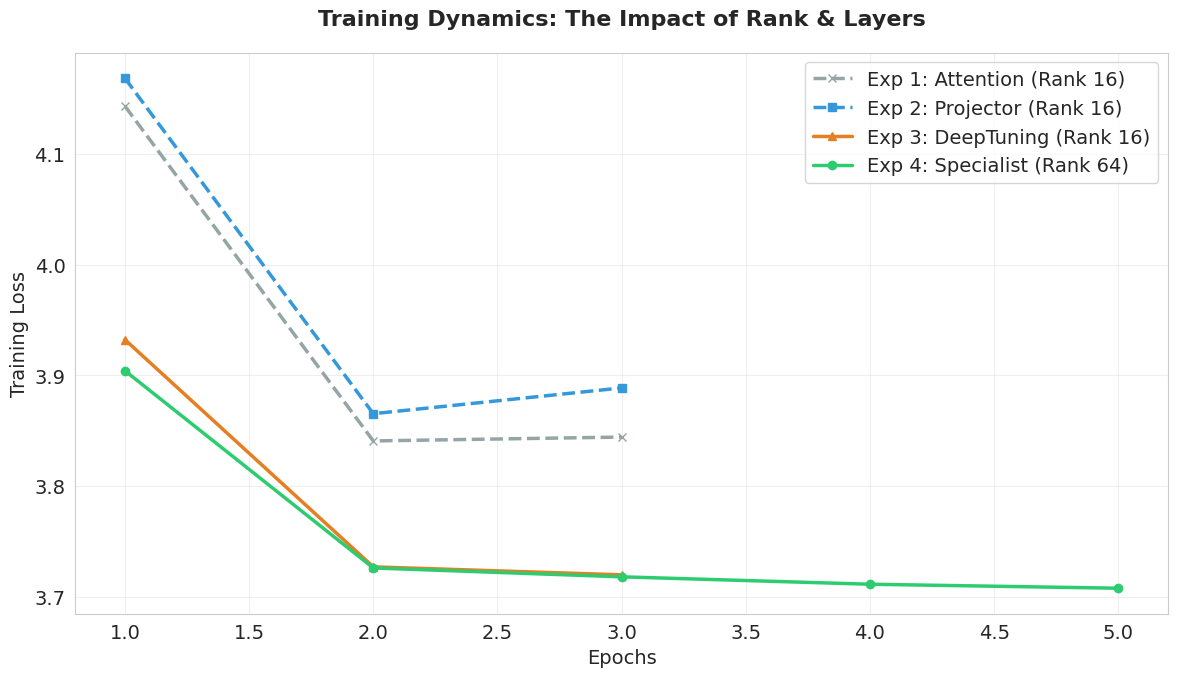


📂 Reading Evaluation Results from: /content/drive/MyDrive/AML_FinalProject/final_smart_results.csv
✅ Saved 'all_experiments_accuracy.png'


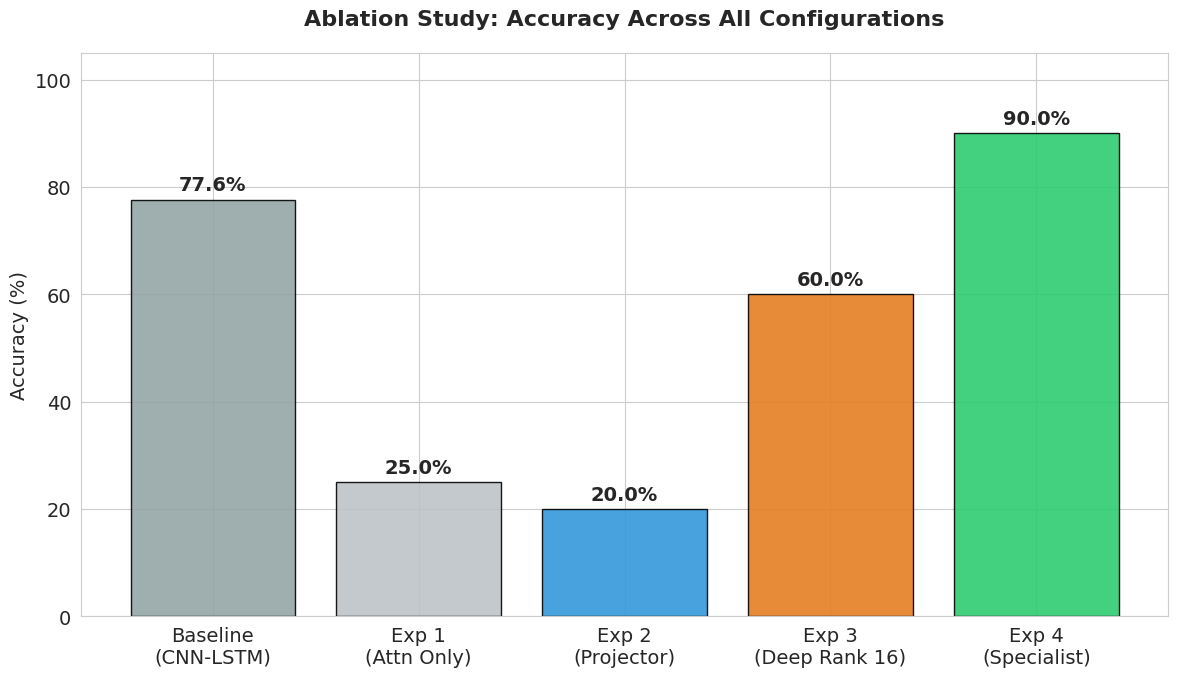

In [5]:
# ==============================================================================
# SECTION 6: VISUALIZATION
# Purpose: Plot Training Loss and Comparative Accuracy.
# ==============================================================================
# ==============================================================================
# SECTION 7 (UPDATED): 4-EXPERIMENT COMPARISON GRAPHS
# Purpose: Visualize Baseline vs. Projector vs. DeepTuning vs. Specialist
# ==============================================================================

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup Plot Style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})

# 1. PATH CONFIGURATION
RESULTS_DIR = "/content/drive/MyDrive/AML_FinalProject/results"
EVAL_CSV_PATH = "/content/drive/MyDrive/AML_FinalProject/final_smart_results.csv"

# ==============================================================================
# GRAPH 1: DYNAMIC TRAINING LOSS (ALL 4 EXPERIMENTS)
# ==============================================================================
print(f"📂 Reading Training Logs from: {RESULTS_DIR}")

def read_loss_log(exp_folder_name):
    """Reads the JSON log for a specific experiment folder."""
    log_path = os.path.join(RESULTS_DIR, exp_folder_name, "training_log.json")
    if os.path.exists(log_path):
        with open(log_path, 'r') as f:
            data = json.load(f)
        # Extract End-of-Epoch Loss
        epoch_losses = []
        for entry in data:
            if entry.get('Step') == 'END':
                epoch_losses.append(entry['Loss'])
        return epoch_losses
    else:
        return []

# Load Data for All 4 Exps
# (Make sure these folder names match your Drive folders exactly)
loss_data = {
    "Exp 1: Attention (Rank 16)": read_loss_log("Exp1_Baseline"),
    "Exp 2: Projector (Rank 16)": read_loss_log("Exp2_Projector"),
    "Exp 3: DeepTuning (Rank 16)": read_loss_log("Exp3_DeepTuning"),
    "Exp 4: Specialist (Rank 64)": read_loss_log("Exp4_HighRank_Specialist")
}

# Define Colors & Styles
styles = {
    "Exp 1": {"color": "#95a5a6", "style": "--", "marker": "x"}, # Grey
    "Exp 2": {"color": "#3498db", "style": "--", "marker": "s"}, # Blue
    "Exp 3": {"color": "#e67e22", "style": "-", "marker": "^"},  # Orange
    "Exp 4": {"color": "#2ecc71", "style": "-", "marker": "o"}   # Green
}

plt.figure(figsize=(12, 7))

# Plot Loop
for label, losses in loss_data.items():
    if losses: # Only plot if data exists
        epochs = range(1, len(losses) + 1)
        # Match style based on label key
        key = label.split(":")[0]
        s = styles.get(key, {"color": "black", "style": "-", "marker": "o"})

        plt.plot(epochs, losses,
                 color=s["color"], linestyle=s["style"], marker=s["marker"],
                 linewidth=2.5, label=label)

plt.title('Training Dynamics: The Impact of Rank & Layers', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('all_experiments_loss.png', dpi=300)
print("✅ Saved 'all_experiments_loss.png'")
plt.show()


# ==============================================================================
# GRAPH 2: ACCURACY COMPARISON (ALL 4 EXPERIMENTS)
# ==============================================================================
if os.path.exists(EVAL_CSV_PATH):
    print(f"\n📂 Reading Evaluation Results from: {EVAL_CSV_PATH}")
    df = pd.read_csv(EVAL_CSV_PATH)

    accuracies = {}

    # 1. Accuracy Check Logic
    def check_acc(row, col_name):
        truth = str(row['answer']).lower().replace('.', '').strip()
        pred = str(row[col_name]).lower().replace('.', '').strip()
        if truth in pred or (pred in truth and len(pred) > 1):
            return 1
        return 0

    # 2. Scan Columns (Auto-detects whatever you ran)
    pred_cols = [c for c in df.columns if c.startswith('Pred_')]
    for col in pred_cols:
        score = df.apply(lambda row: check_acc(row, col), axis=1).mean() * 100
        # Clean Names for Display
        clean_name = col.replace("Pred_", "").replace(" (Bonus)", "").replace("_", " ")
        if "Exp1" in clean_name: clean_name = "Exp 1\n(Attn Only)"
        elif "Exp2" in clean_name: clean_name = "Exp 2\n(Projector)"
        elif "Deep" in clean_name or "Exp3" in clean_name: clean_name = "Exp 3\n(Deep Rank 16)"
        elif "HighRank" in clean_name or "Specialist" in clean_name: clean_name = "Exp 4\n(Specialist)"

        accuracies[clean_name] = score

    # 3. Add Baseline Manually if missing
    if not any("Baseline" in k for k in accuracies.keys()):
        accuracies["Baseline\n(CNN-LSTM)"] = 77.64

    # 4. Sorting Logic (Baseline -> Exp 1 -> Exp 2 -> Exp 3 -> Exp 4)
    def sort_key(name):
        if "CNN" in name: return 0
        if "Exp 1" in name: return 1
        if "Exp 2" in name: return 2
        if "Exp 3" in name: return 3
        if "Exp 4" in name: return 4
        return 5

    sorted_names = sorted(accuracies.keys(), key=sort_key)
    sorted_values = [accuracies[k] for k in sorted_names]

    # 5. Colors
    bar_colors = []
    for n in sorted_names:
        if "CNN" in n: bar_colors.append('#95a5a6') # Grey
        elif "Exp 1" in n: bar_colors.append('#bdc3c7') # Light Grey
        elif "Exp 2" in n: bar_colors.append('#3498db') # Blue
        elif "Exp 3" in n: bar_colors.append('#e67e22') # Orange
        elif "Exp 4" in n: bar_colors.append('#2ecc71') # Green
        else: bar_colors.append('gray')

    plt.figure(figsize=(12, 7))
    bars = plt.bar(sorted_names, sorted_values, color=bar_colors, edgecolor='black', alpha=0.9)

    # Labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%',
                 ha='center', va='bottom', fontweight='bold')

    plt.title('Ablation Study: Accuracy Across All Configurations', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 105)
    plt.tight_layout()
    plt.savefig('all_experiments_accuracy.png', dpi=300)
    print("✅ Saved 'all_experiments_accuracy.png'")
    plt.show()

else:
    print(f"❌ Error: CSV not found at {EVAL_CSV_PATH}")